In [2]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [3]:
s_path=Path.cwd()
#s_prt_path=s_path.parent

sRutaPrint=s_path.joinpath('Print')
sRutaPrint

WindowsPath('c:/Alejo/Eje de Planeación/Análisis Eléctrico/ScriptsPython/Print')

In [3]:
objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI

In [4]:
df =objetoAPI.get_collections()   

### Descargar las colecciones disponibles en la API

In [5]:
df.to_csv('Collections.csv')
df.head(5)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...


#### Descarga de generación real

In [50]:
df_dataGen=pd.DataFrame()

for year in range(2013,2025,1):

    print(year)
    if year<2024:
        monthIni=1
        dayIni=1
        monthFin=12
        dayFin=31
    else:
        monthIni=1
        dayIni=1
        monthFin=8
        dayFin=18        

    FechaIni=dt.date(year, monthIni, dayIni)
    FechaFin=dt.date(year, monthFin, dayFin)

    df_GenReal= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                            "Gene",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                            "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                            FechaIni,       #Corresponde a la fecha inicial de la consulta
                            FechaFin)      #Corresponde a la fecha final de la consulta
    
   
    
    df_GenReal.fillna(0, inplace=True)

    df_Rec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ListadoRecursos",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
    
    df_Rec.drop(['Date','Id'],axis=1,inplace=True)

    df_Gen_Type=df_GenReal.merge(df_Rec,left_on=['Values_code'],right_on=['Values_Code'], how='left')

    df_Gen_Type=df_Gen_Type[df_Gen_Type.Values_Disp=='NO DESPACHADO CENTRALMENTE']

    columns_name=list(df_Gen_Type.columns)[2:26]
    icont=1
    df_Gen_Type['Gendia']=0
    for iname in columns_name:
        df_Gen_Type['Gendia']=df_Gen_Type['Gendia']+df_Gen_Type[iname]/1000
        df_Gen_Type.rename(columns={iname:icont},inplace=True)
        icont+=1
    
    df_Gen_Type=df_Gen_Type[['Values_Name','Values_Type','Values_Disp','Date','Gendia']]
    df_DayType=df_Gen_Type.groupby(['Date','Values_Type','Values_Disp'])[['Gendia']].sum()
    df_DayType.reset_index(inplace=True)

    df_dataGen=pd.concat([df_dataGen,df_DayType])

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [52]:
with pd.ExcelWriter(str(sRutaPrint) + '\GenRealDia.xlsx',engine='xlsxwriter') as writer:
    df_dataGen.to_excel(writer, sheet_name='GendiaMenor', index=False)

In [18]:
df_dataAp=pd.DataFrame()

for year in range(2013,2025,1):

    print(year)
    if year<2024:
        monthIni=1
        dayIni=1
        monthFin=12
        dayFin=31
    else:
        monthIni=1
        dayIni=1
        monthFin=8
        dayFin=18    

    FechaIni=dt.date(year, monthIni, dayIni)
    FechaFin=dt.date(year, monthFin, dayFin)
             
    df_Aportes= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                            "AporEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                            "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                            FechaIni,       #Corresponde a la fecha inicial de la consulta
                            FechaFin)      #Corresponde a la fecha final de la consulta
    df_Aportes.rename(columns={'Value':'Aportes'},inplace=True)

    df_dataAp=pd.concat([df_dataAp,df_Aportes])

df_dataAp=df_dataAp[['Date','Aportes']]

df_dataAp['Aportes']=df_dataAp['Aportes']/1000

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [19]:
with pd.ExcelWriter(str(sRutaPrint) + '\AportesDia.xlsx',engine='xlsxwriter') as writer:
    df_dataAp.to_excel(writer, sheet_name='AportesDia', index=False)

### Cargar datos y ejecutar modelo

In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [2]:
s_path=Path.cwd()
#s_prt_path=s_path.parent

sRutaPrint=s_path.joinpath('Print')
sRutaPrint

WindowsPath('c:/Alejo/Eje de Planeación/Análisis Eléctrico/ScriptsPython/Print')

In [3]:
df_data=pd.read_excel(str(sRutaPrint) + '\GenRealDia.xlsx', sheet_name='GendiaMenor')
df_dataAp=pd.read_excel(str(sRutaPrint) + '\AportesDia.xlsx', sheet_name='AportesDia')

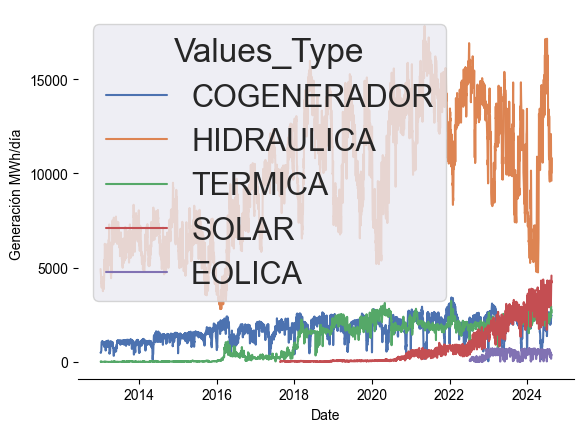

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Graficar de nuevo los datos
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.set(font_scale=2)
sns.lineplot(data = df_data, x='Date', y='Gendia',hue='Values_Type')
ax.set_ylabel('Generación MWh/día')
ax.set_facecolor('white')
sns.despine(left=True)

In [5]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='Weekday':
          return row['Date'].weekday()
     elif tipo=='TypeDay':
          if row['Date'] in co_holidays:
               return 3
          elif row['Date'].weekday()==5:
               return 2
          elif row['Date'].weekday()==6:
               return 3
          else:
               return 1
     elif tipo=='Month':
          return row['Date'].month
     elif tipo=='Year':
          return row['Date'].year

# Realizar pronóstico

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import numpy as np

c:\Users\eramirez\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tensorflow WARNING From c:\Users\eramirez\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



### Definición de funciones

In [7]:
def train_test_split(dataframe, porcentaje):
  ntrain = int(len(dataframe)*porcentaje)
  ntest = len(dataframe) - ntrain

  if ntest==0:
    datos_train = dataframe[:]
    datos_test  = []  
  else:
    datos_train = dataframe[:-ntest]
    datos_test  = dataframe[-ntest:]

  return ntrain, datos_train, ntest, datos_test

In [74]:
def create_sequence(series,lags,Fechas,Yout):
  X = []
  y = []
  yfecha=[]
  for i in range(len(series) - lags):
      if Yout==1:
        X.append(series[i:i+lags,1:])
        y.append(series[i+lags, 0])
        yfecha.append(Fechas[i+lags])
      else:
        X.append(series[i:i+lags,1:])
        y.append(series[i+lags, 0])
        yfecha.append(Fechas[i+lags])        
  X = np.array(X)
  y = np.array(y)
  yfecha=np.array(yfecha)
  return X,y,yfecha

In [48]:
def rnn_exog(X_train, y_train, X_test, y_test, n_features,lags, neurons=50, activation='relu', optimizer='adam', epochs=50, batch_size=32):

  # model = Sequential()
  # model.add(LSTM(neurons, activation=activation, input_shape=(lags, n_features)))
  # model.add(Dense(1))
  # model.compile(optimizer=optimizer, loss='mse')

  tf.keras.backend.clear_session()
  
  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(80, activation='relu', input_shape=(lags, n_features), return_sequences=True),
      # tf.keras.layers.LSTM(48, activation='LeakyReLU', return_sequences=True),
      tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
      tf.keras.layers.Flatten(),
      # tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(70, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1)
  ], name='lstm')
  
  loss = tf.keras.losses.Huber()
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
  
  model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])

  model_hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))




  return model

In [10]:
def prediccion(model,X_train,X_test,scaler,f_train,f_test): 

    predicciones_train = model.predict(X_train)
    predicciones_test = model.predict(X_test)
    
    # la función stack se usa para retornar la data a la dimensión ooriginal para que funcione el inverse
    predicciones_train = scaler.inverse_transform(np.hstack((predicciones_train, X_train[:, -1, 1:])))
    predicciones_test = scaler.inverse_transform(np.hstack((predicciones_test, X_test[:, -1, 1:])))

    predicciones_train = pd.DataFrame({'Date':f_train,'pred':predicciones_train[:, 0]})
    predicciones_test = pd.DataFrame({'Date':f_test,'pred':predicciones_test[:, 0]})


    return predicciones_train, predicciones_test

In [11]:
def Prediction_graphs(dfModel,pred_train,pred_test):
  fig, ax = plt.subplots(figsize=(20, 5))
  fig.suptitle('Resultado de la predicción de Genración')
  plt.plot(dfModel['Date'], dfModel['Gendia'],label='Original')
  plt.plot(pred_train['Date'], pred_train['pred'],label='Train')
  plt.plot(pred_test['Date'], pred_test['pred'],label='Test')
  ax.set_ylabel('Generación MWh/día')
  ax.set_facecolor('white')
  ax.legend()

  ntest=pred_test.shape[0]

  fig, ax = plt.subplots(figsize=(20, 5))
  plt.plot(dfModel['Date'][-ntest:], dfModel['Gendia'][-ntest:],label='Original')
  plt.plot(pred_test['Date'], pred_test['pred'],label='Test')
  ax.set_ylabel('Gen [MWh/dia]')
  ax.legend()


  fig, ax = plt.subplots(figsize=(20, 5))
  plt.plot(dfModel['Date'][-90:], dfModel['Gendia'][-90:],label='Original')
  plt.plot(pred_test['Date'][-90:], pred_test['pred'][-90:],label='Test')
  ax.set_ylabel('Gen [MWh/dia]')
  ax.legend()
  



### Preparación del dataset

In [70]:
df_GenHid=df_data.copy()
# df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia','Aportes']]

df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia']]

# Agregar tipo de día
df_GenHid['TypeDay']=df_GenHid.apply(lambda row: typedays(row,tipo='TypeDay'),axis=1)
# Definir día de la semana
df_GenHid['Weekday']=df_GenHid.apply(lambda row: typedays(row,tipo='Weekday'),axis=1)
# Definir mes
df_GenHid['Month']=df_GenHid.apply(lambda row: typedays(row,tipo='Month'),axis=1)
# Definir año
df_GenHid['Year']=df_GenHid.apply(lambda row: typedays(row,tipo='Year'),axis=1)

# Remover la fecha al dataset
col=df_GenHid.columns[1:]
dataset=df_GenHid[col]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4248 entries, 1 to 16036
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gendia   4248 non-null   float64
 1   TypeDay  4248 non-null   int64  
 2   Weekday  4248 non-null   int64  
 3   Month    4248 non-null   int64  
 4   Year     4248 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 199.1 KB


### Considerar Retardos

In [71]:
df_GenHid['d_1'] = df_GenHid['Gendia'].shift(1)  # 1-day lag
df_GenHid['d_2'] = df_GenHid['Gendia'].shift(2)  # 2-day lag
df_GenHid['d_7'] = df_GenHid['Gendia'].shift(7)  # 7-day lag
df_GenHid = df_GenHid.dropna()

In [72]:
print(df_GenHid.head(10))
print(df_GenHid.shape)
print(df_GenHid.tail(10))

         Date      Gendia  TypeDay  Weekday  Month  Year         d_1  \
21 2013-01-08  4246.61898        1        1      1  2013  4213.16135   
24 2013-01-09  4133.33919        1        2      1  2013  4246.61898   
27 2013-01-10  4128.58333        1        3      1  2013  4133.33919   
30 2013-01-11  3942.48944        1        4      1  2013  4128.58333   
33 2013-01-12  3969.76991        2        5      1  2013  3942.48944   
36 2013-01-13  4210.18619        3        6      1  2013  3969.76991   
39 2013-01-14  4165.28521        1        0      1  2013  4210.18619   
42 2013-01-15  4211.38978        1        1      1  2013  4165.28521   
45 2013-01-16  4348.37398        1        2      1  2013  4211.38978   
48 2013-01-17  4282.48747        1        3      1  2013  4348.37398   

           d_2         d_7  
21  4363.09553  4925.62655  
24  4213.16135  4799.93577  
27  4246.61898  4731.06990  
30  4133.33919  4684.38623  
33  4128.58333  4620.25446  
36  3942.48944  4363.09553  
39  

### Procedimiento de entrenamiento y predicción

In [75]:
# División del dataset original
ntrainO, trainO, ntestO, testO = train_test_split(df_GenHid, 0.80)

In [76]:
dfModel=df_GenHid[df_GenHid.columns[1:]]
Fechas=np.array(df_GenHid[df_GenHid.columns[0]])

In [78]:
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(dfModel)

porcentajeSplit=0.8
nlags=1
[X,y,SecFecha]=create_sequence(series,lags=nlags,Fechas=Fechas,Yout=1)

ntrain, X_train, ntest, X_test = train_test_split(X, porcentajeSplit)
ntrain, y_train, ntest, y_test = train_test_split(y, porcentajeSplit)
ntrain, f_train, ntest, f_test = train_test_split(SecFecha, porcentajeSplit)

In [82]:
import time
# Crear y entrenar forecaster
inicio = time.time()

n_features=X_train.shape[2]

model = rnn_exog(   X_train,
                    y_train,
                    X_test, 
                    y_test,
                    n_features=n_features,
                    lags=nlags,
                    neurons=50,
                    activation='relu',
                    optimizer='adam',
                    epochs=25,
                    batch_size=30)

fin = time.time()

# Calcula la diferencia de tiempo
print(fin - inicio)

Epoch 1/25
114/114 [==============================] - 2s 4ms/step - loss: 0.0317 - mae: 0.1830 - mape: 66062.5391 - val_loss: 0.0056 - val_mae: 0.0831 - val_mape: 21.1087
Epoch 2/25
114/114 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0691 - mape: 45046.3164 - val_loss: 0.0069 - val_mae: 0.0989 - val_mape: 22.2612
Epoch 3/25
114/114 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0608 - mape: 35625.3555 - val_loss: 0.0033 - val_mae: 0.0638 - val_mape: 14.0979
Epoch 4/25
114/114 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0574 - mape: 15032.0605 - val_loss: 0.0031 - val_mae: 0.0614 - val_mape: 13.5880
Epoch 5/25
114/114 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0553 - mape: 9121.6924 - val_loss: 0.0027 - val_mae: 0.0569 - val_mape: 11.6303
Epoch 6/25
114/114 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0548 - mape: 6910.7280 - val_loss: 0.0026 - val_mae: 0.0

In [83]:
[pred_train,pred_test]=prediccion(model,X_train,X_test,scaler,f_train,f_test)

27/27 [==============================] - 0s 641us/step


ValueError: operands could not be broadcast together with shapes (3392,7) (8,) (3392,7) 

In [ ]:
print('Data Original')
print(trainO.shape)
print(testO.shape)

print('Data Modeificada para el modelo')
print(X_train.shape)
print(X_test.shape)
print(pred_train.shape)
print(pred_test.shape)


Data Original
(3398, 6)
(850, 6)
Data Modeificada para el modelo
(3374, 30, 5)
(844, 30, 5)
(3374, 2)
(844, 2)


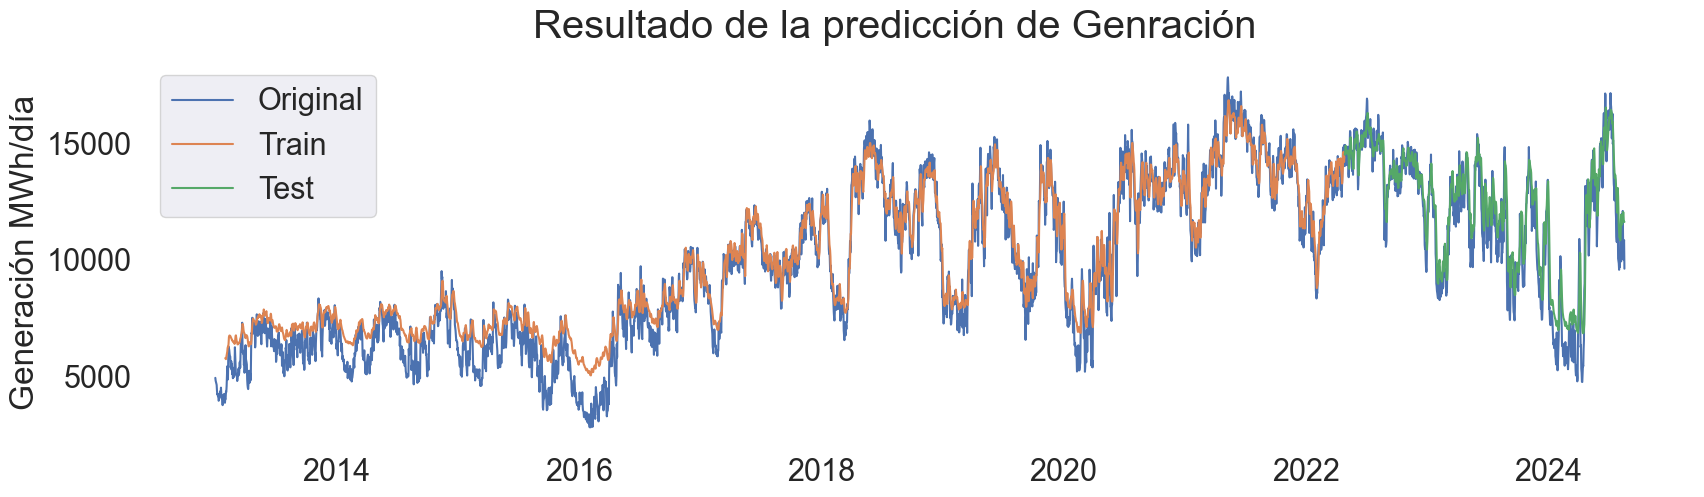

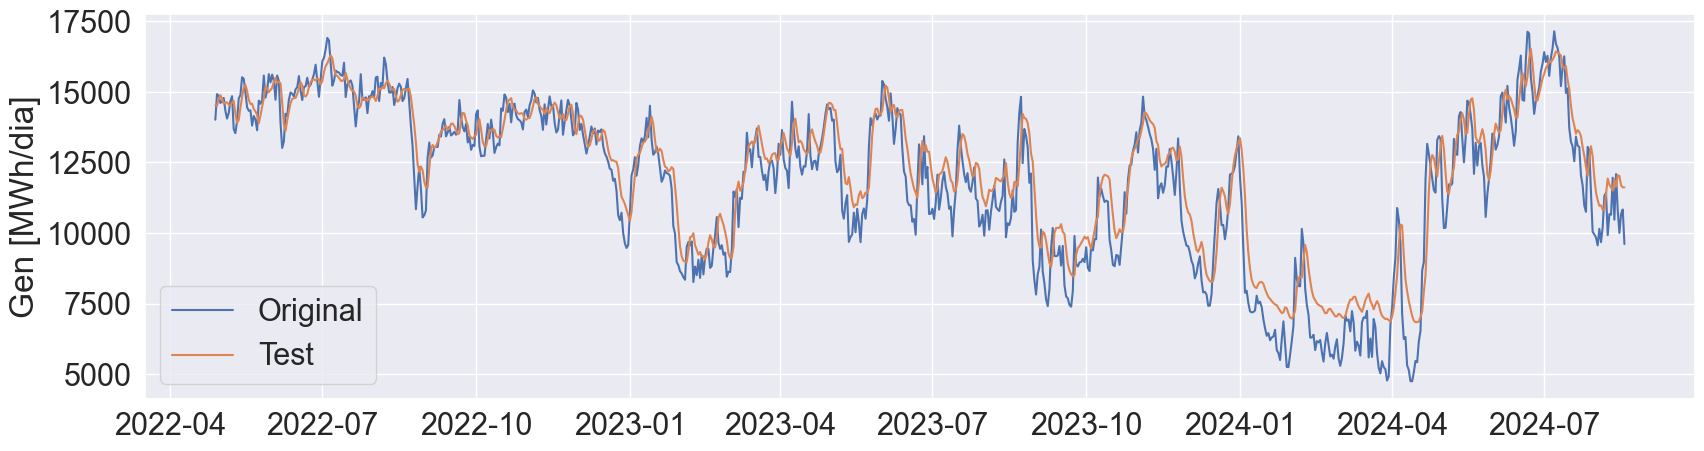

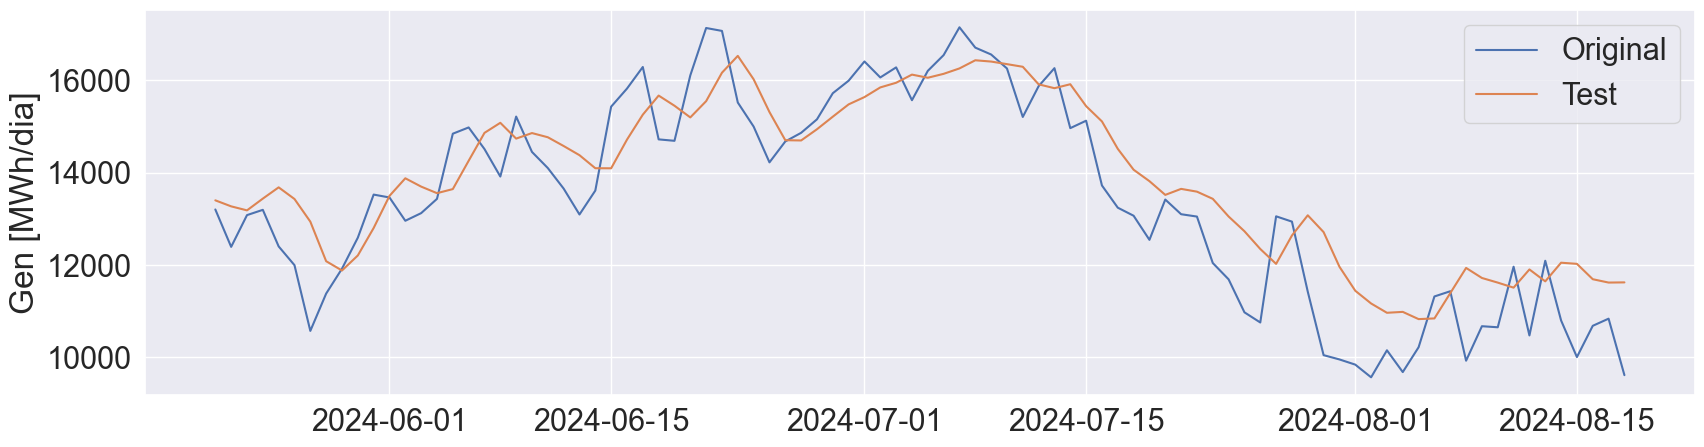

In [ ]:
# Gráficos
Prediction_graphs(df_GenHid,pred_train,pred_test)

### Error en train

In [ ]:
# Cálculo de error para toda la predicción
y_true=df_GenHid['Gendia'][nlags:-ntest]
y_pred=pred_train['pred']
error_test_mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
error_test_rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
error_test_mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
error_test_medae = median_absolute_error(y_true=y_true, y_pred=y_pred)
error_test_mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)

print(f"El error MSE   de test es: {error_test_mse}")
print(f"El error RMSE  de test es: {error_test_rmse}")
print(f"El error MAE   de test es: {error_test_mae}")
print(f"El error MedAE de test es: {error_test_medae}")
print(f"El error MAPE  de test es: {error_test_mape}")

El error MSE   de test es: 777692.3670898691
El error RMSE  de test es: 881.8686790502705
El error MAE   de test es: 700.9888179240062
El error MedAE de test es: 590.7771126545049
El error MAPE  de test es: 0.10201379023227086


### Error en test

In [ ]:
# Cálculo de error para toda la predicción
y_true=df_GenHid['Gendia'][-ntest:]
y_pred=pred_test['pred']
error_test_mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
error_test_rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
error_test_mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
error_test_medae = median_absolute_error(y_true=y_true, y_pred=y_pred)
error_test_mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)

print(f"El error MSE   de test es: {error_test_mse}")
print(f"El error RMSE  de test es: {error_test_rmse}")
print(f"El error MAE   de test es: {error_test_mae}")
print(f"El error MedAE de test es: {error_test_medae}")
print(f"El error MAPE  de test es: {error_test_mape}")

El error MSE   de test es: 1045068.899817254
El error RMSE  de test es: 1022.28611445977
El error MAE   de test es: 804.1419523804653
El error MedAE de test es: 648.8273576023157
El error MAPE  de test es: 0.08344275508003689


### Estiamación los próximos 3 meses

#### Entrenar con todo

In [37]:
df_Gen=df_data.copy()
# df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia','Aportes']]

df_Gen=df_Gen[df_Gen.Values_Type=='HIDRAULICA'][['Date','Gendia']]

# Agregar tipo de día
df_Gen['TypeDay']=df_Gen.apply(lambda row: typedays(row,tipo='TypeDay'),axis=1)
# Definir día de la semana
df_Gen['Weekday']=df_Gen.apply(lambda row: typedays(row,tipo='Weekday'),axis=1)
# Definir mes
df_Gen['Month']=df_Gen.apply(lambda row: typedays(row,tipo='Month'),axis=1)
# Definir año
df_Gen['Year']=df_Gen.apply(lambda row: typedays(row,tipo='Year'),axis=1)

dfModel=df_Gen[df_Gen.columns[1:]]

In [38]:
dfModel
l_clo=dfModel.columns

In [49]:
scaler1 = MinMaxScaler()
series = scaler1.fit_transform(dfModel)

porcentajeSplit=0.9
nlags=24
[X,y,SecFecha]=create_sequence(series,lags=nlags,Fechas=Fechas)

ntrain, X_train, ntest, X_test = train_test_split(X, porcentajeSplit)
ntrain, y_train, ntest, y_test = train_test_split(y, porcentajeSplit)
ntrain, f_train, ntest, f_test = train_test_split(SecFecha, porcentajeSplit)

In [50]:
print(X_train.shape)
print(y_train.shape)

(3801, 24, 5)
(3801,)


In [51]:
import time
# Crear y entrenar forecaster
inicio = time.time()

n_features=5

model = rnn_exog(   X_train,
                    y_train,
                    X_test, 
                    y_test,
                    n_features=n_features,
                    lags=nlags,
                    neurons=50,
                    activation='relu',
                    optimizer='adam',
                    epochs=25,
                    batch_size=30)

fin = time.time()

# Calcula la diferencia de tiempo
print(fin - inicio)

Epoch 1/25
127/127 [==============================] - 3s 11ms/step - loss: 0.0138 - mae: 0.1165 - mape: 55181.9180 - val_loss: 0.0110 - val_mae: 0.1262 - val_mape: 34.0432
Epoch 2/25
127/127 [==============================] - 1s 10ms/step - loss: 0.0046 - mae: 0.0734 - mape: 30062.3398 - val_loss: 0.0066 - val_mae: 0.0945 - val_mape: 25.5543
Epoch 3/25
127/127 [==============================] - 1s 10ms/step - loss: 0.0038 - mae: 0.0669 - mape: 8553.3232 - val_loss: 0.0065 - val_mae: 0.0937 - val_mape: 25.0215
Epoch 4/25
127/127 [==============================] - 1s 10ms/step - loss: 0.0037 - mae: 0.0657 - mape: 19319.7559 - val_loss: 0.0051 - val_mae: 0.0787 - val_mape: 19.7657
Epoch 5/25
127/127 [==============================] - 1s 10ms/step - loss: 0.0036 - mae: 0.0651 - mape: 14813.0322 - val_loss: 0.0060 - val_mae: 0.0890 - val_mape: 23.7992
Epoch 6/25
127/127 [==============================] - 1s 10ms/step - loss: 0.0032 - mae: 0.0610 - mape: 17211.7051 - val_loss: 0.0045 - val_m

In [52]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo

def typedaysUnico(Date,tipo):

     if tipo=='Weekday':
          return Date.weekday()
     elif tipo=='TypeDay':
          if Date in co_holidays:
               return 3
          elif Date.weekday()==5:
               return 2
          elif Date.weekday()==6:
               return 3
          else:
               return 1
     elif tipo=='Month':
          return Date.month
     elif tipo=='Year':
          return Date.year

In [53]:
delta=dt.timedelta(days=1)
last_row_iloc = df_GenHid.iloc[-1,0] + delta
last_row_iloc = last_row_iloc.strftime("%Y-%m-%d")

sFechaIni=last_row_iloc
sFechaFin='2024-11-30'

#Camniar a formato fecha
d_FechaIni=dt.datetime.strptime(sFechaIni,'%Y-%m-%d')
d_FechaFin=dt.datetime.strptime(sFechaFin,'%Y-%m-%d')

print(d_FechaIni)
print(d_FechaFin)



2024-08-19 00:00:00
2024-11-30 00:00:00


In [54]:
seriesForest=series.copy()

# Inicializar fecha
d_Fecha=d_FechaIni
ndays=0
f_proy=[]
while d_Fecha<=d_FechaFin:
    print(d_Fecha)
    SliceSerie=seriesForest[-nlags:]
    X1=SliceSerie.reshape(1,SliceSerie.shape[0], n_features)

    Prediction = model.predict(X1)

    if n_features>1:
        l_new=[0,
            typedaysUnico(d_Fecha,tipo='TypeDay'),
            typedaysUnico(d_Fecha,tipo='Weekday'),
            typedaysUnico(d_Fecha,tipo='Month'),
            typedaysUnico(d_Fecha,tipo='Year') ]
        
        l_new = scaler1.transform(pd.DataFrame([l_new],columns=list(l_clo)))
        l_new[0,0]=Prediction[0][0]
    else:
        l_new=[]
        l_new.append(Prediction[0][0])

    seriesForest=np.vstack([seriesForest, l_new])

    ndays=ndays+1
    f_proy.append(d_Fecha)
    d_Fecha=d_Fecha+delta


2024-08-19 00:00:00
1/1 [==============================] - 0s 212ms/step
2024-08-20 00:00:00
1/1 [==============================] - 0s 27ms/step
2024-08-21 00:00:00
1/1 [==============================] - 0s 16ms/step
2024-08-22 00:00:00
1/1 [==============================] - 0s 11ms/step
2024-08-23 00:00:00
1/1 [==============================] - 0s 32ms/step
2024-08-24 00:00:00
1/1 [==============================] - 0s 22ms/step
2024-08-25 00:00:00
1/1 [==============================] - 0s 16ms/step
2024-08-26 00:00:00
1/1 [==============================] - 0s 6ms/step
2024-08-27 00:00:00
1/1 [==============================] - 0s 16ms/step
2024-08-28 00:00:00
1/1 [==============================] - 0s 19ms/step
2024-08-29 00:00:00
1/1 [==============================] - 0s 24ms/step
2024-08-30 00:00:00
1/1 [==============================] - 0s 29ms/step
2024-08-31 00:00:00
1/1 [==============================] - 0s 31ms/step
2024-09-01 00:00:00
1/1 [==============================] - 0s 31

In [55]:
f_proy1=list(df_GenHid['Date'][-30:])
f_proy1=f_proy1 + f_proy
print(len(f_proy1))
ndays1=ndays+30

134


In [56]:
PredicFinal = scaler1.inverse_transform(seriesForest)
#PredicFinal = pd.DataFrame({'Date':f_proy1,'pred':PredicFinal[-ndays1:, 0]})
PredicFinal = pd.DataFrame({'Date':f_proy,'pred':PredicFinal[-ndays:, 0]})

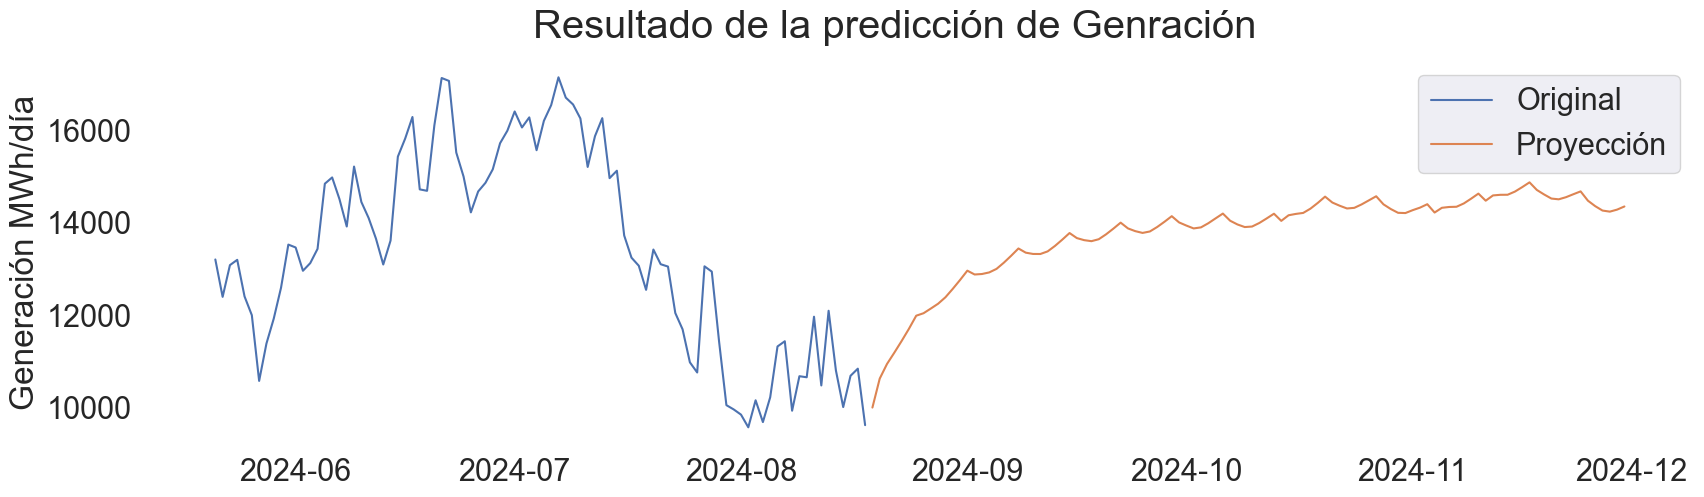

In [57]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.suptitle('Resultado de la predicción de Genración')
plt.plot(df_GenHid['Date'][-90:], df_GenHid['Gendia'][-90:],label='Original')
plt.plot(PredicFinal['Date'], PredicFinal['pred'],label='Proyección')
ax.set_ylabel('Generación MWh/día')
ax.set_facecolor('white')
ax.legend()